In [1]:
import os, sys
sys.path.append('/home/oleg/Prog/Science/ship_tracks_recognition/functions')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import linear_model
from math import *
from Y_views_ransac import *
from UV_views import *
from MarginLinearRegression import *
%matplotlib inline

In [2]:
all_mctracks = pd.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pd.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pd.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

In [3]:
match_table = {}
for i in all_hits.Index:
        match_table[i] = all_hits.TrackID[i]

In [4]:
reco = np.array(pd.read_csv('./Data/RecognizedTracks.csv'))[:, 1]

# Linear regression

In [7]:
warnings.simplefilter('ignore')
bad_1 = []
regr_type = 0#linear regr
all_events = len(reco)
ind = 0
n_min = 7
plane_width = 0.85
for i in reco:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if index==False:
        bad_1.append(i)
recognized_events = all_events - len(bad_1)
print 1.0 * recognized_events / all_events

0.949685534591


# mlr

In [6]:
warnings.simplefilter('ignore')
bad_2 = []
regr_type = 1#mlr
all_events = len(reco)
ind = 0
n_min = 7
plane_width = 0.85
for i in reco:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if index==False:
        bad_2.append(i)
recognized_events = all_events - len(bad_2)
print 1.0 * recognized_events / all_events

0.949685534591


# Ransac

In [5]:
warnings.simplefilter('ignore')
bad_3 = []
regr_type = 2#ransac
all_events = len(reco)
ind = 0
n_min = 7
plane_width = 0.85
for i in reco:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if index==False:
        bad_3.append(i)
recognized_events = all_events - len(bad_3)
print 1.0 * recognized_events / all_events

0.949685534591


In [8]:
bad_1

[1036,
 27,
 558,
 1090,
 84,
 606,
 1722,
 1756,
 1762,
 2277,
 1848,
 381,
 970,
 2040,
 2029,
 1533]

In [9]:
bad_2==bad_1

True

In [10]:
bad_2==bad_3

True

# Analysis

In [11]:
def dist2Track(point, track):
    return np.abs(- track[0] * point[0] + point[1] - track[1]) / np.sqrt(track[0]**2 + 1.0)

In [12]:
def picture(event_ids):
    for k in event_ids:
        for t in range(3):
            regr_type = t
            event = all_hits[all_hits.event==k]
            ind = 0
            plane_width = 0.85
            n_min = 7
            tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
            crossing_points = linking_table

            event = modify_for_yz_analysis_1_2(event)

            if regr_type==0:
                print 'lin_regr'
            elif regr_type==1:
                print 'mlr'
            else:
                print 'ransac'
            print str(k)+':'
            fig = plt.figure(figsize=(15,10))
            ax = fig.add_subplot(1, 1, 1)

            original_tracks = set(event.TrackID)
            if -2 in original_tracks:
                original_tracks.remove(-2)

            for j in original_tracks:
                track = event[event.TrackID==j]
                Wz = track.Wz.values
                Wy = track.Wy.values
                Z = track.Z.values
                Y = track.Y.values
                R = track.dist2Wire.values
                StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

                # originl track and hits
                plt.plot(Z, Y, c='r', label='original track '+str(j))
                plt.scatter(Z, Y, c='r', label='original hits')

                # The wire centers and dist2wire
                plt.scatter(Wz, Wy, c='b', label='wire centers')
                for index in range(0, Z.shape[0]):
                    circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
                    ax.add_patch(circ)

            for j in tracks:
                # crossing point
                Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
                Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
                Y_line_crossing = Z_crossing * tracks[j][0] + tracks[j][1]

                plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
                plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))
                N = len(crossing_points[j])
                dists_0 = []
                dists_1 = []
                for i in crossing_points[j]:
                    dists_1.append(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) / event.dist2Wire[i])
                    dists_0.append(np.abs(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) - event.dist2Wire[i]))

            plt.legend(loc='best')
            plt.show()

lin_regr
1036:


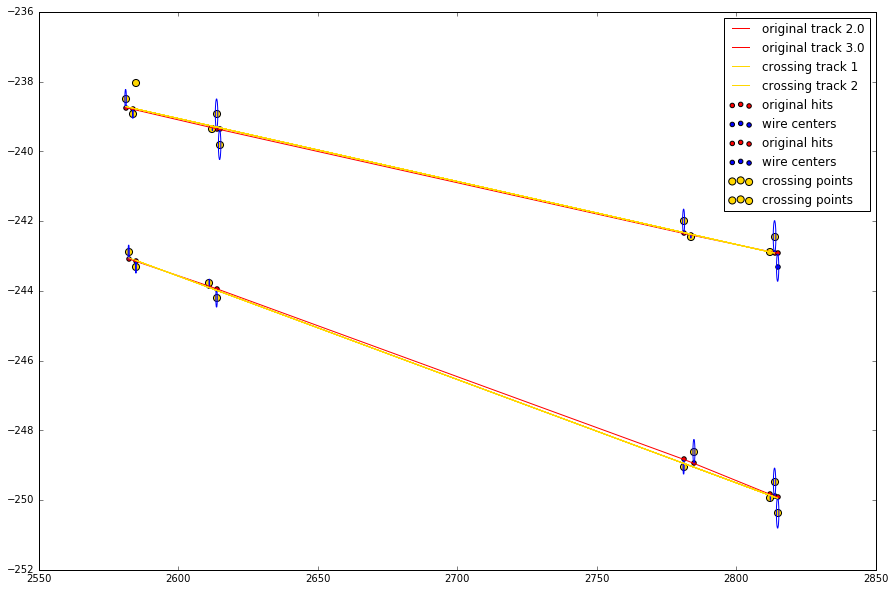

mlr
1036:


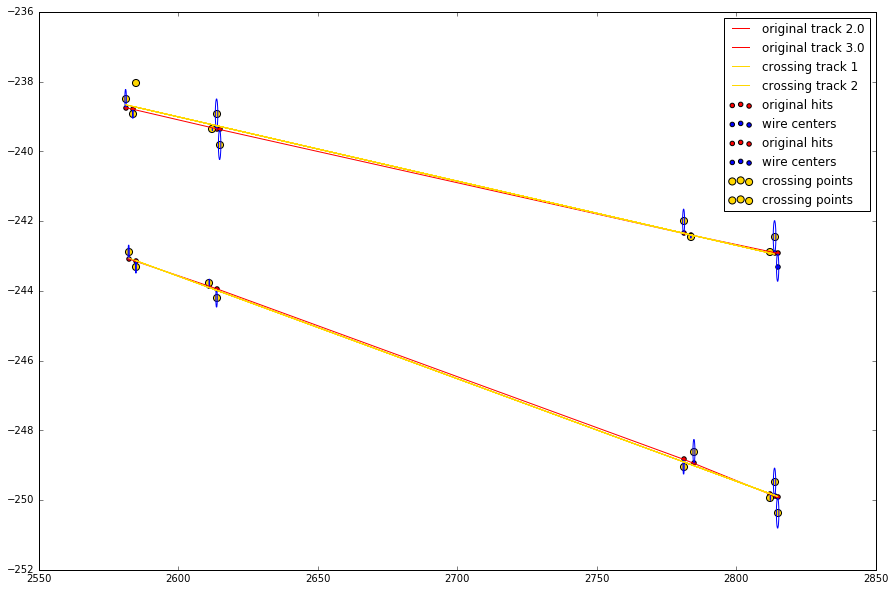

ransac
1036:


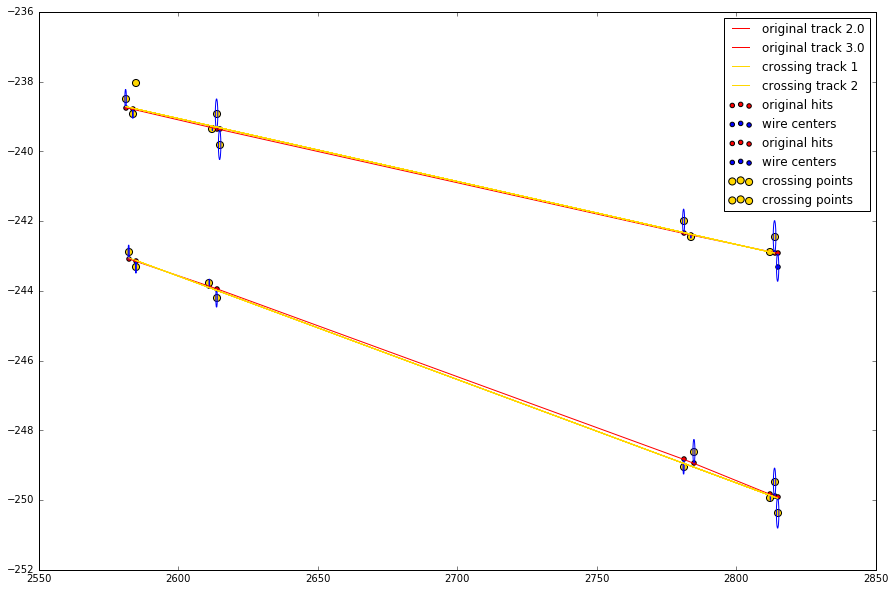

lin_regr
27:


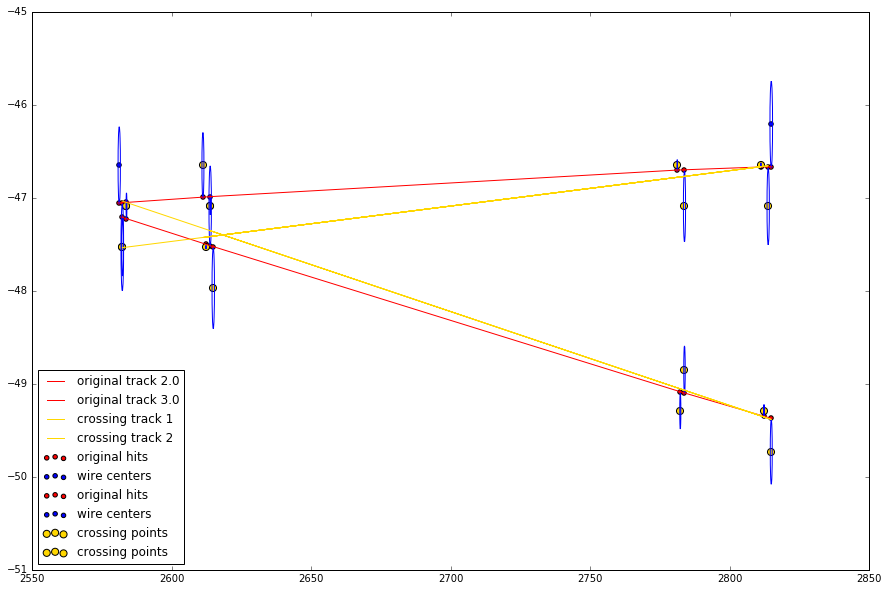

mlr
27:


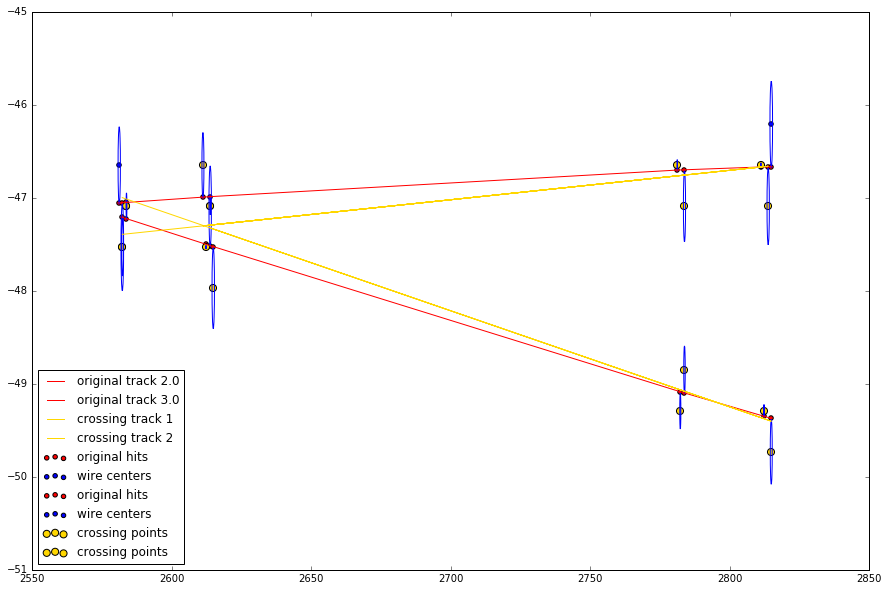

ransac
27:


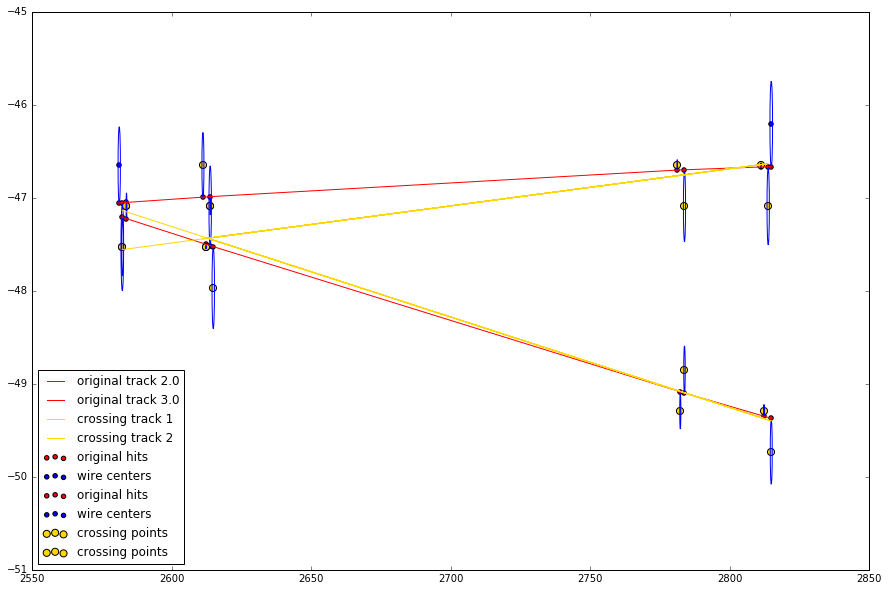

lin_regr
558:


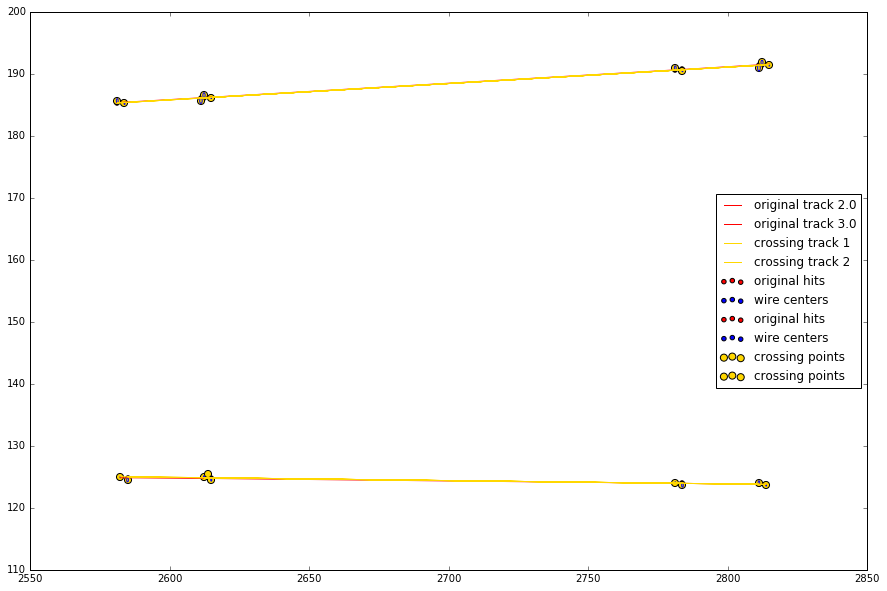

mlr
558:


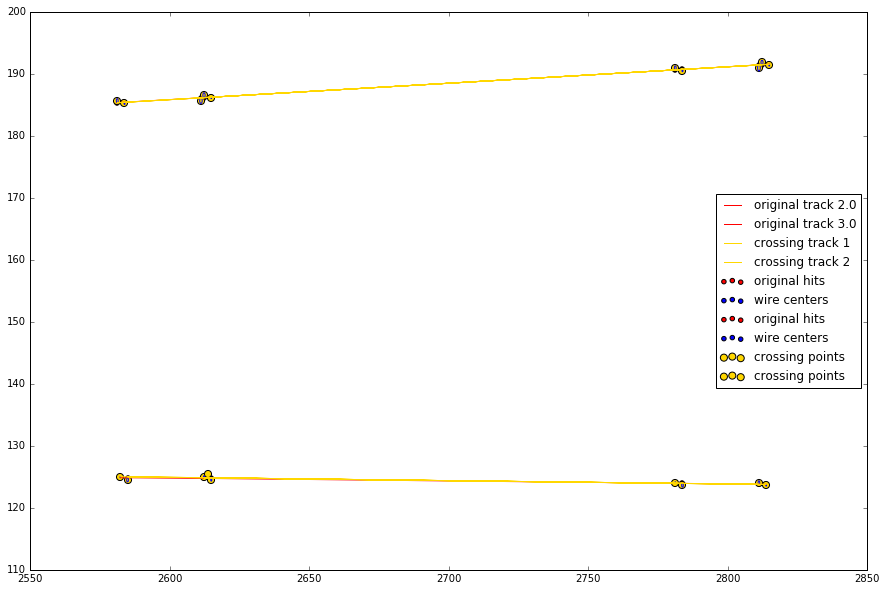

ransac
558:


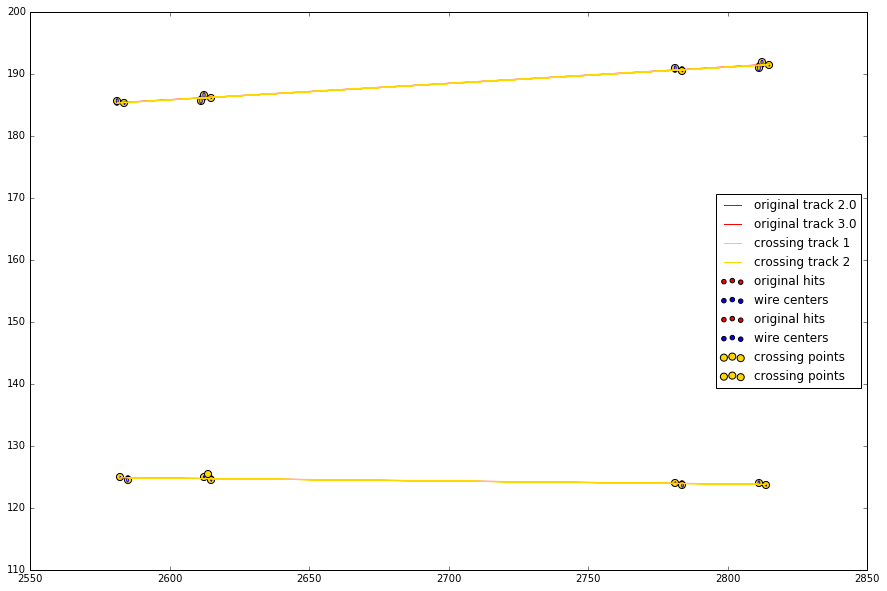

lin_regr
1090:


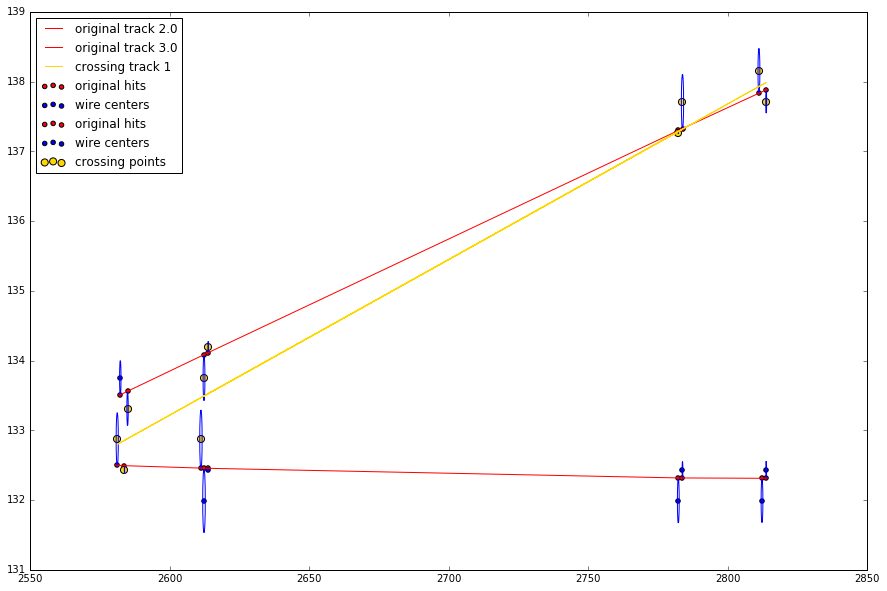

mlr
1090:


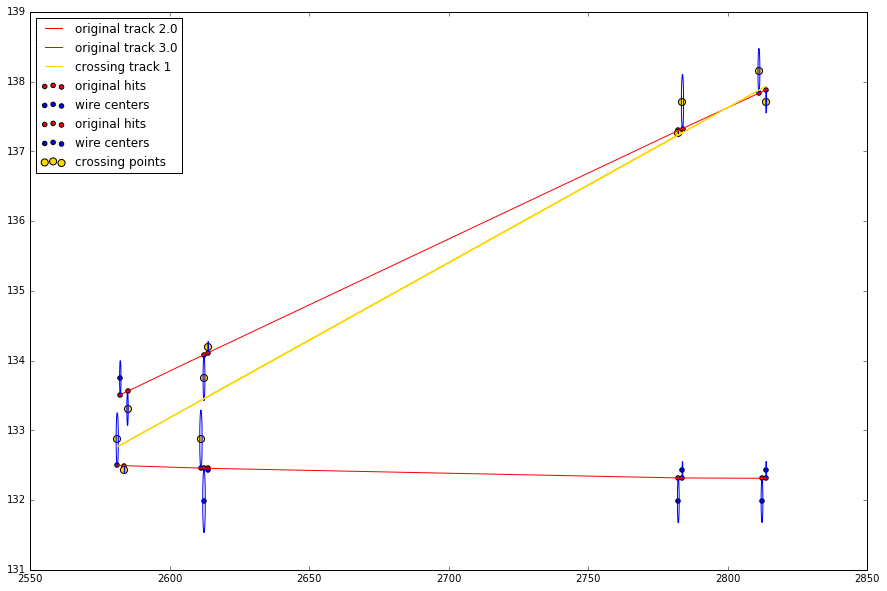

ransac
1090:


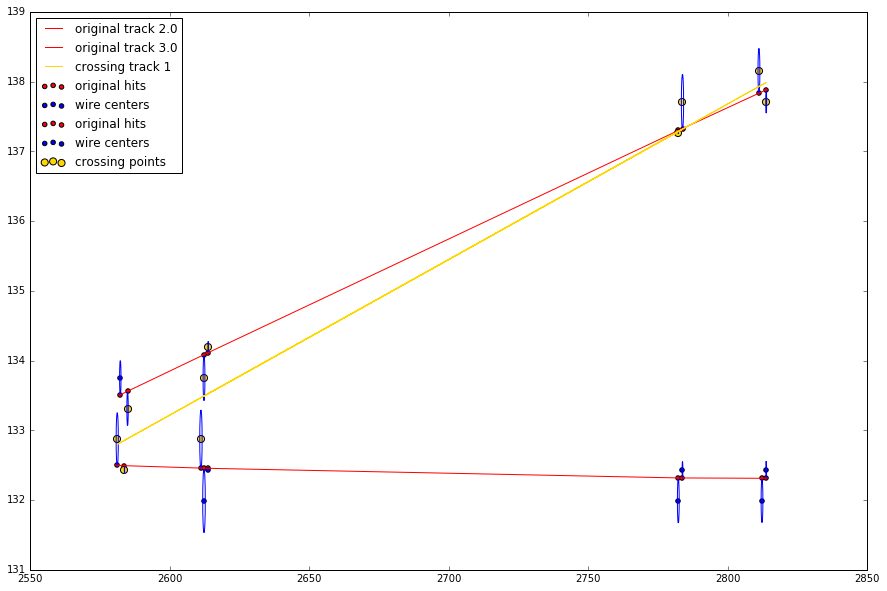

lin_regr
84:


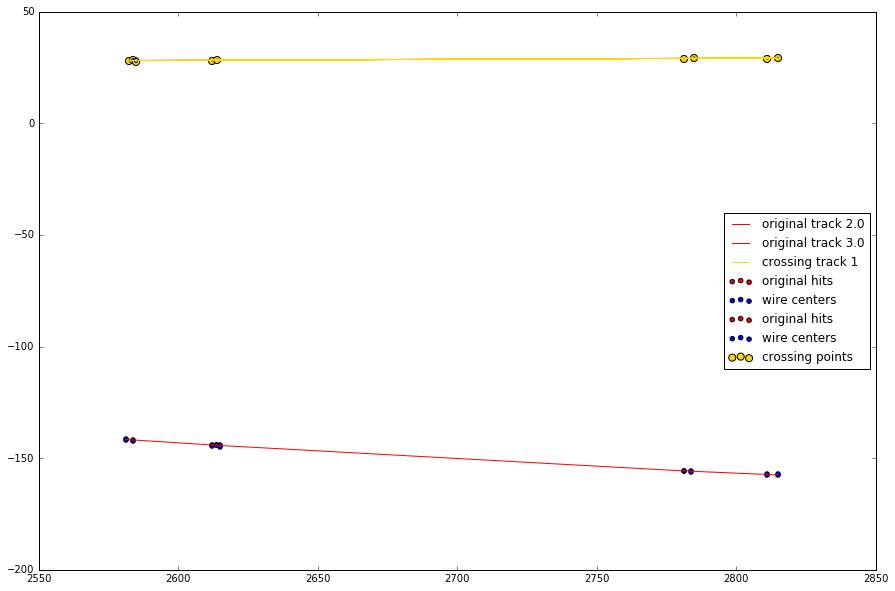

mlr
84:


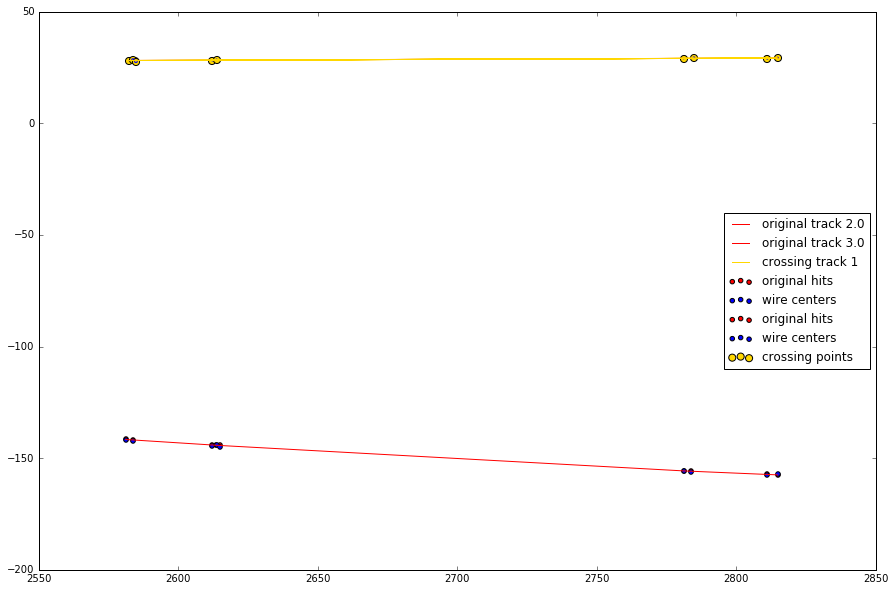

ransac
84:


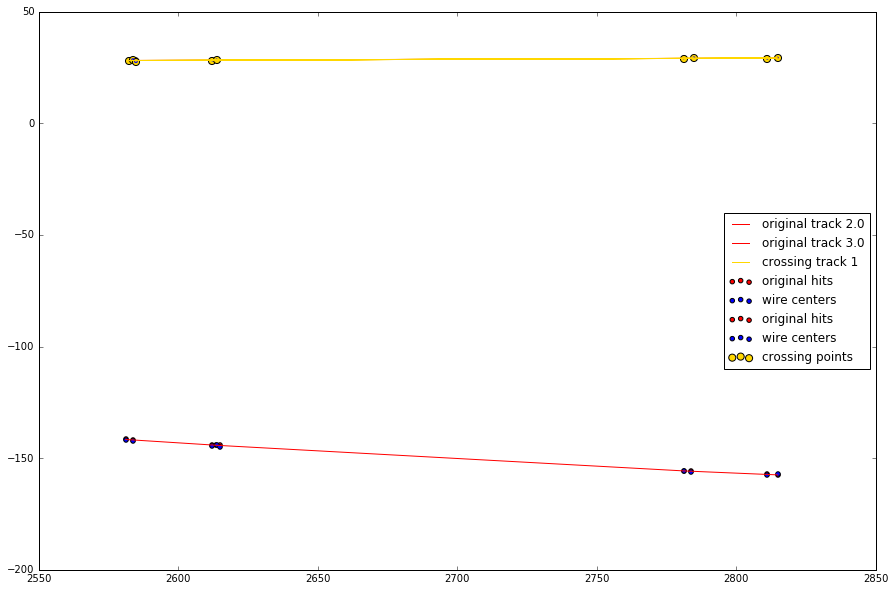

lin_regr
606:


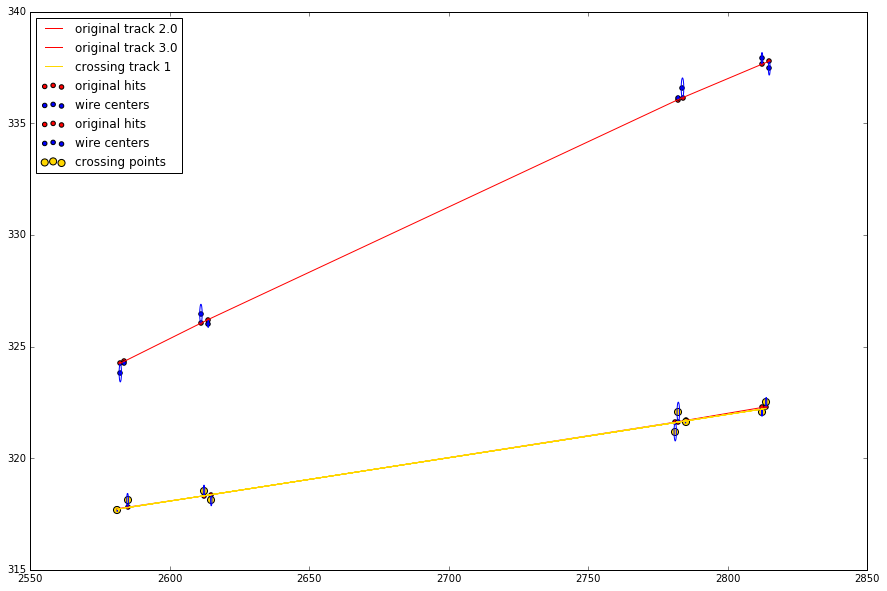

mlr
606:


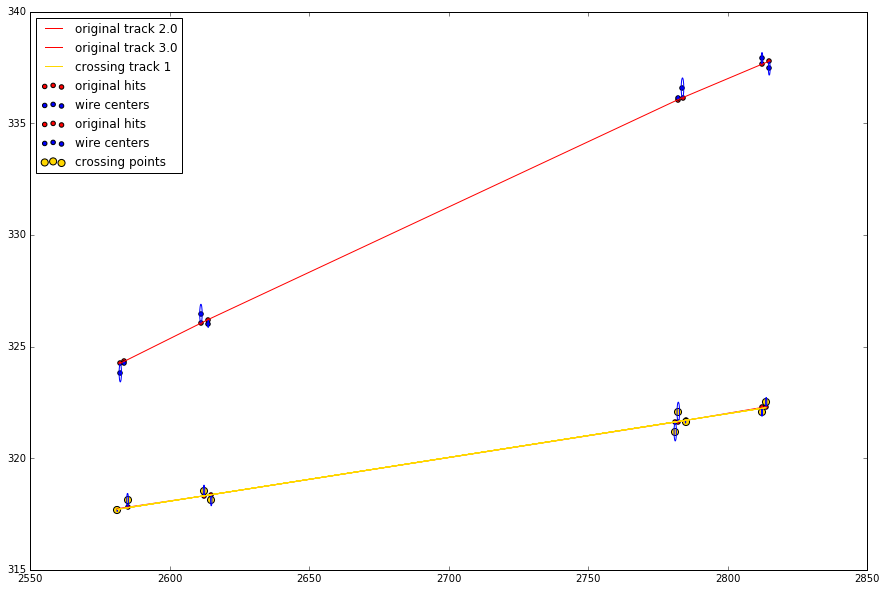

ransac
606:


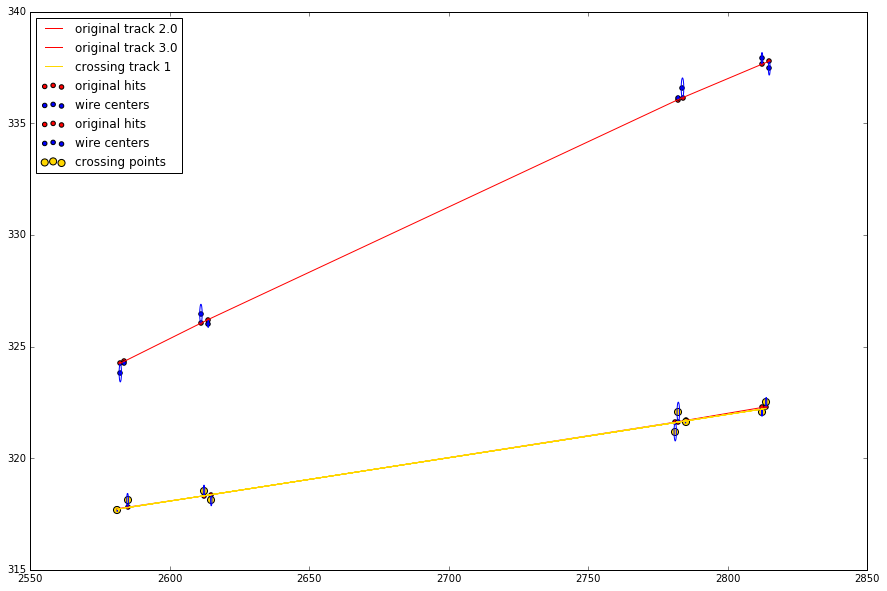

lin_regr
1722:


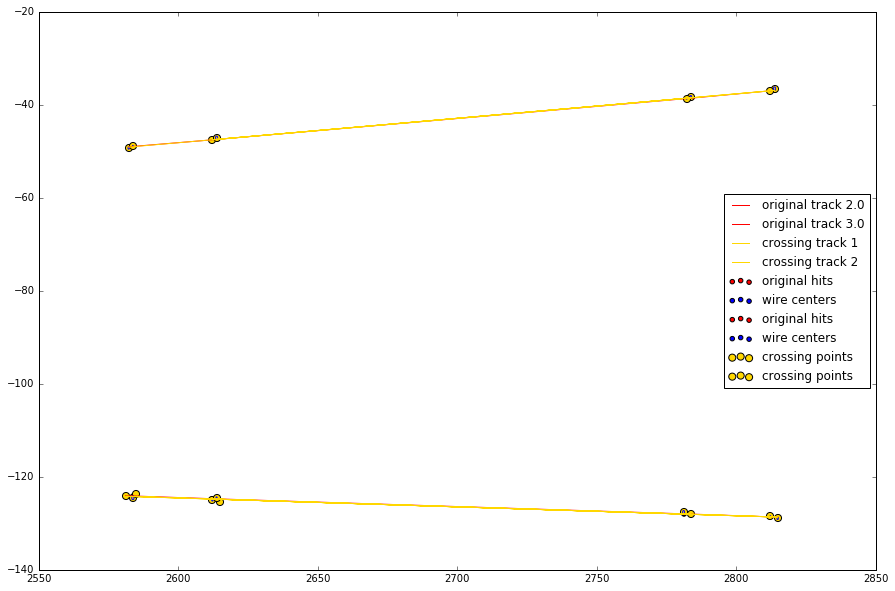

mlr
1722:


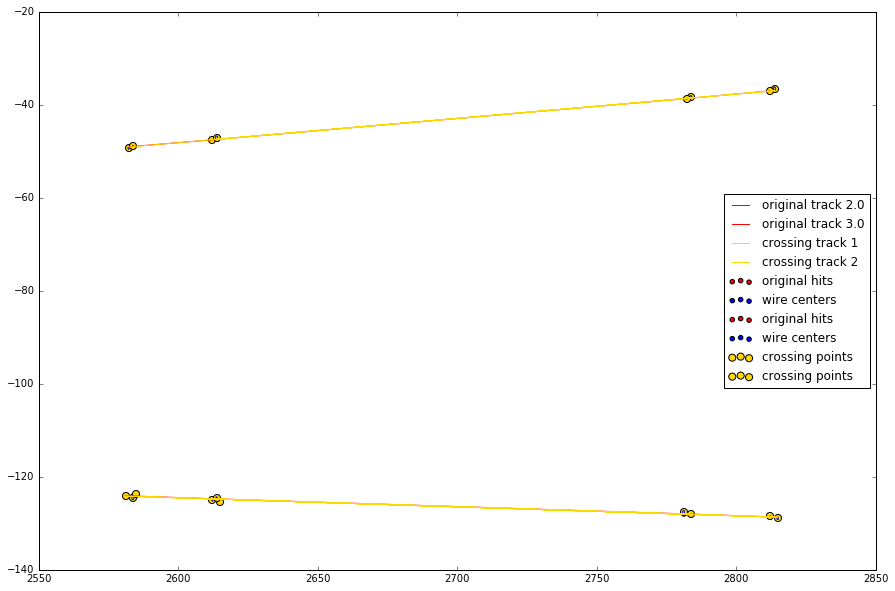

ransac
1722:


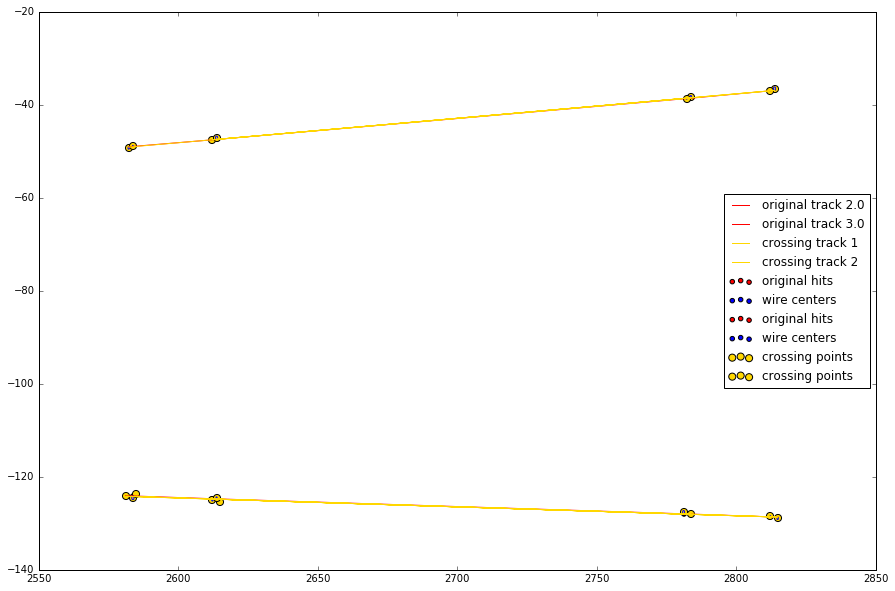

lin_regr
1756:


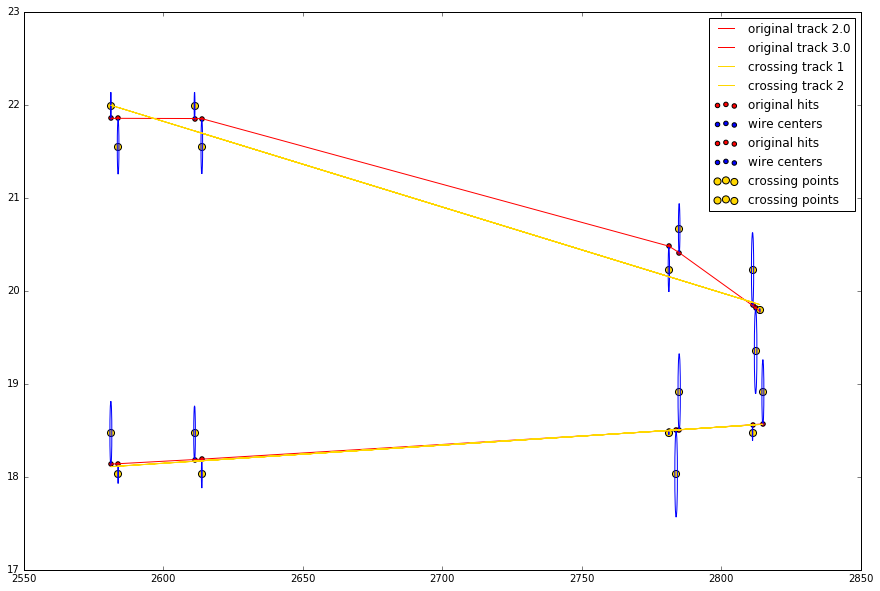

mlr
1756:


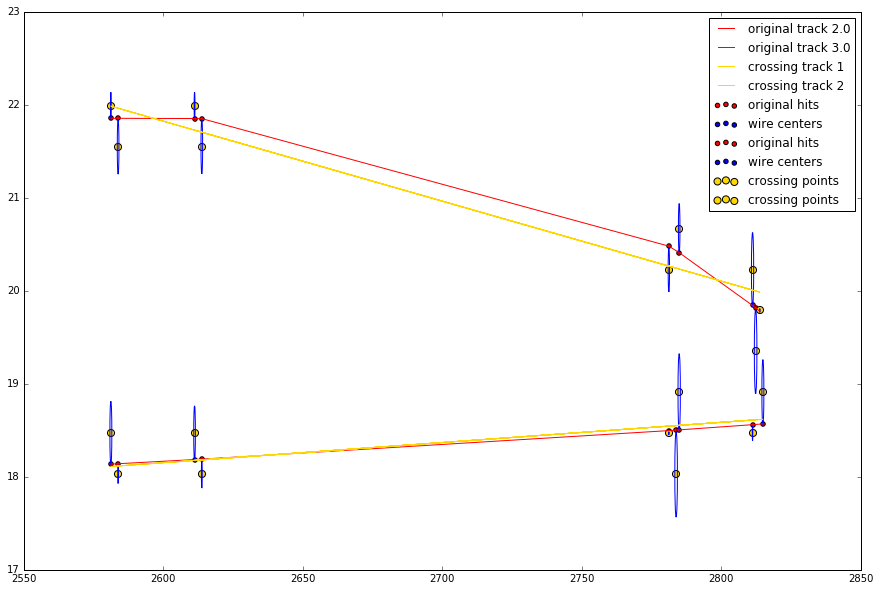

ransac
1756:


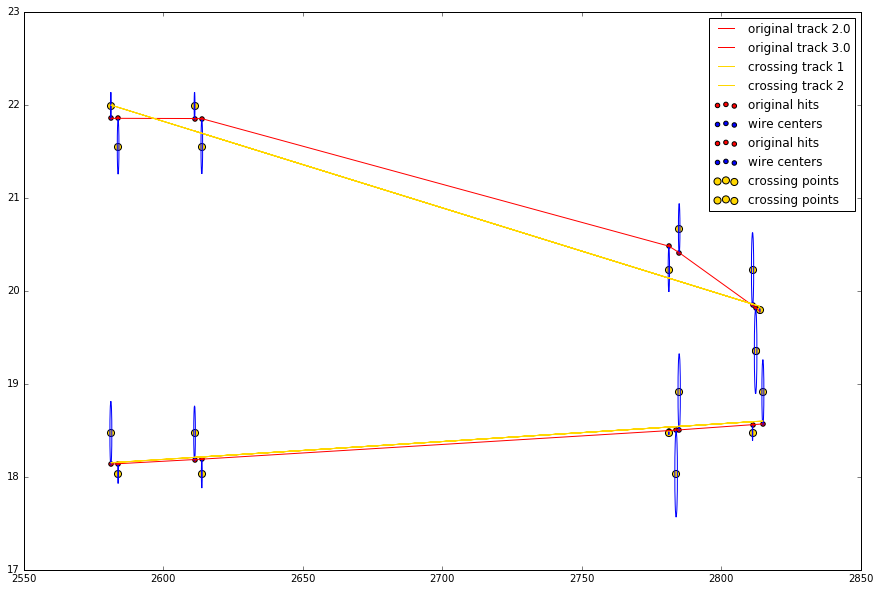

lin_regr
1762:


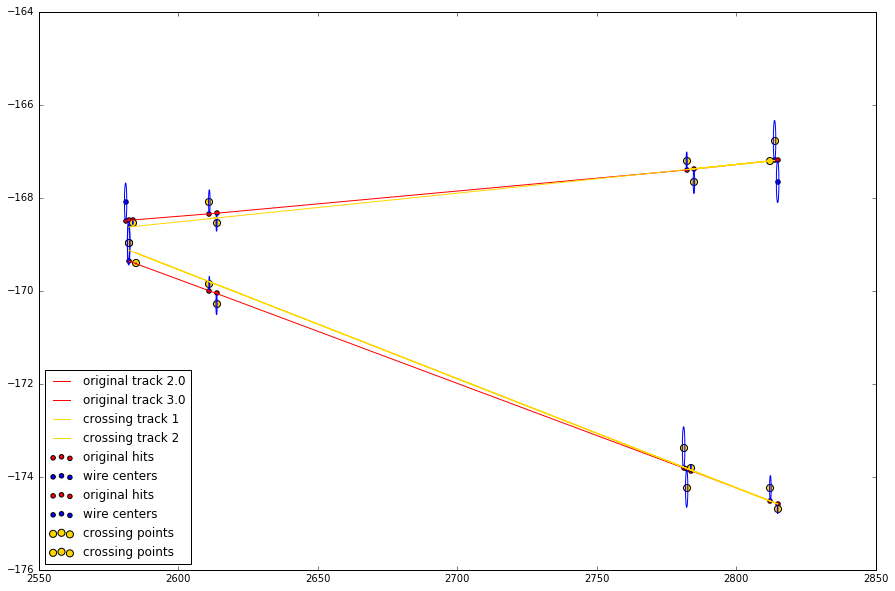

mlr
1762:


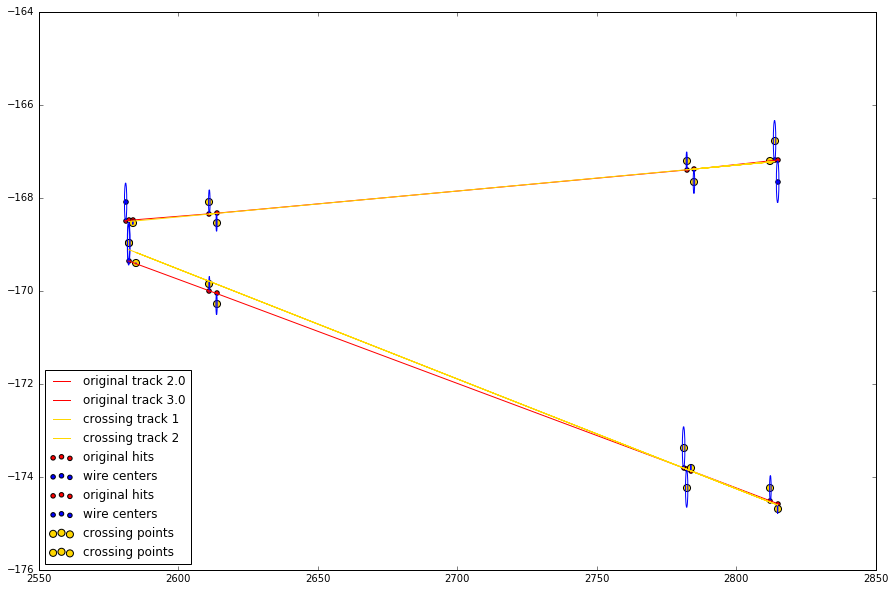

ransac
1762:


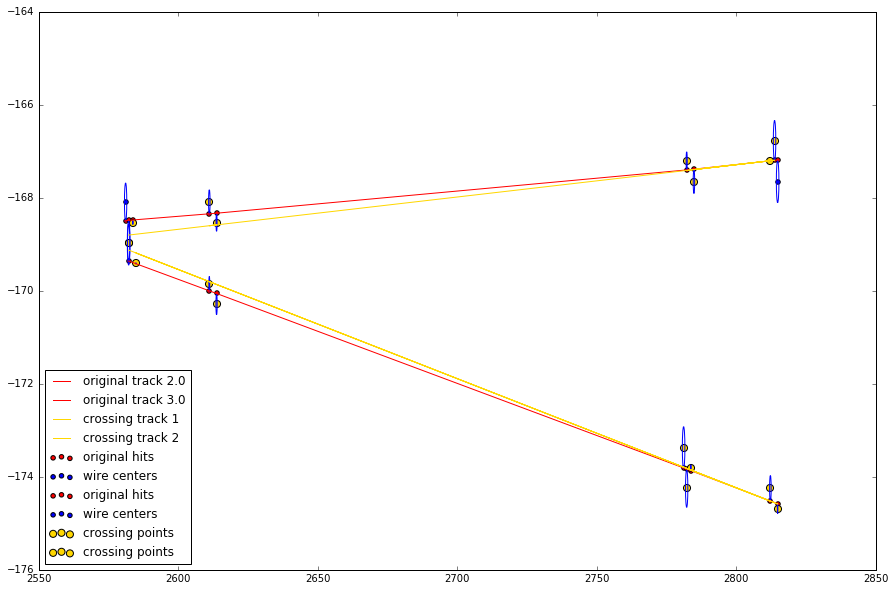

lin_regr
2277:


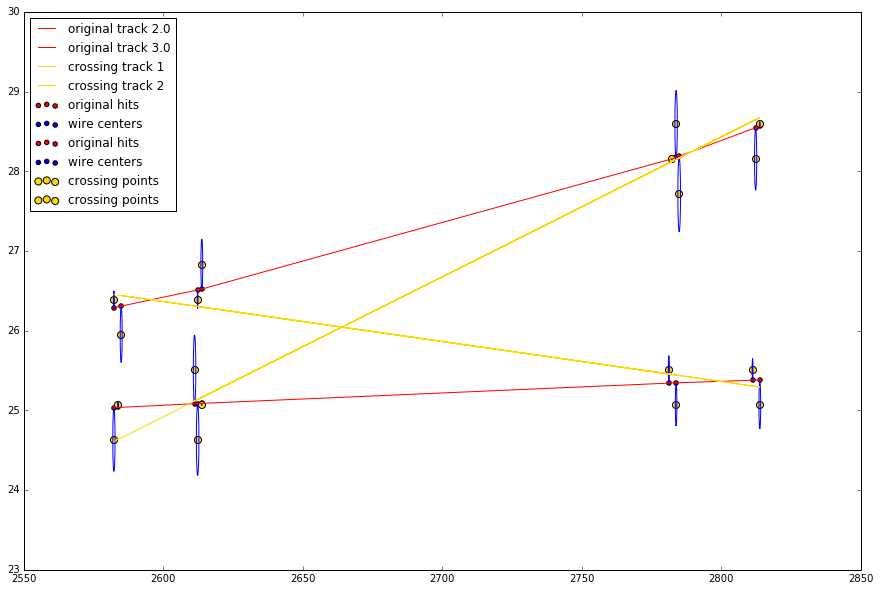

mlr
2277:


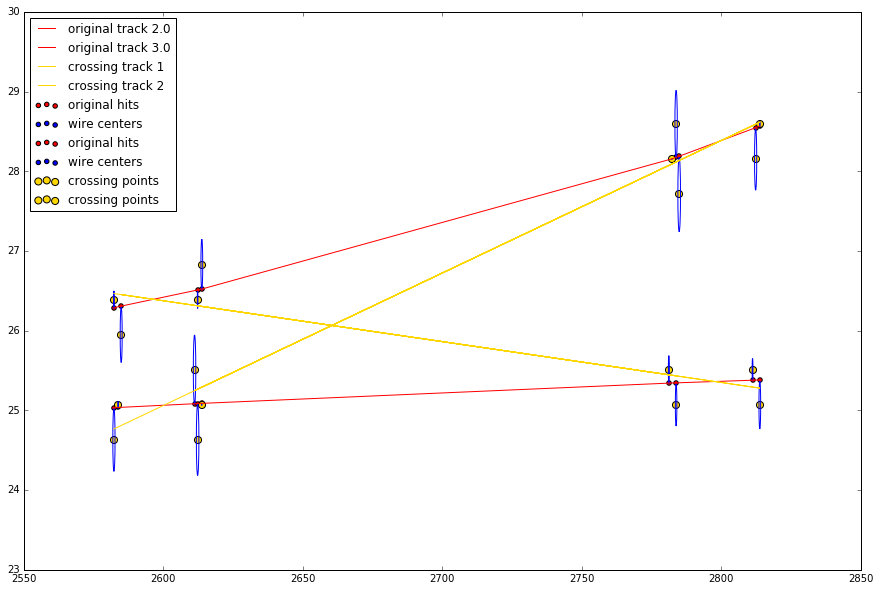

ransac
2277:


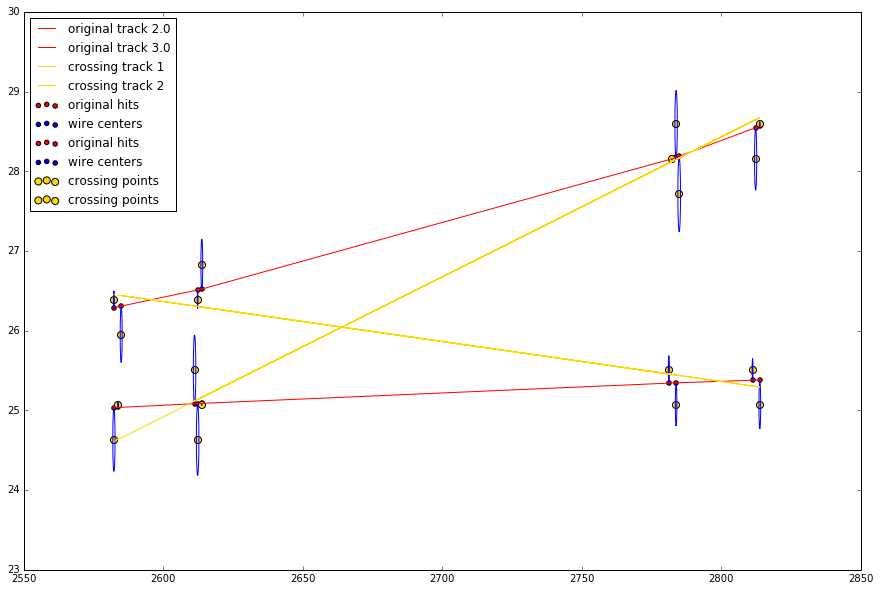

lin_regr
1848:


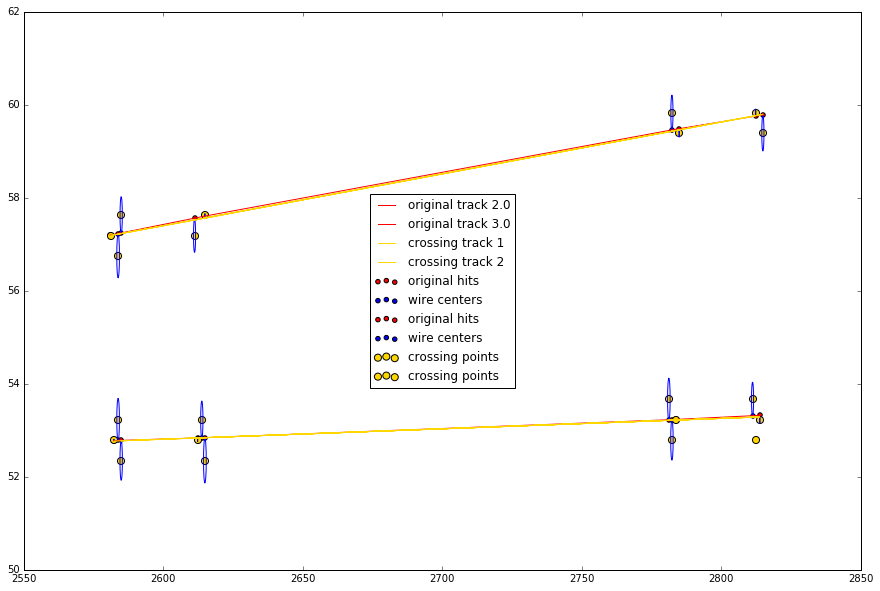

mlr
1848:


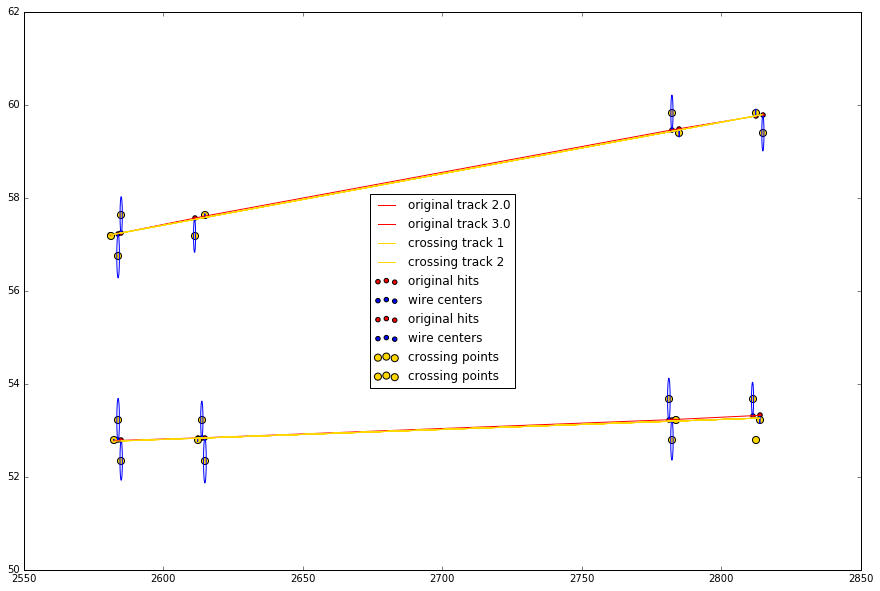

ransac
1848:


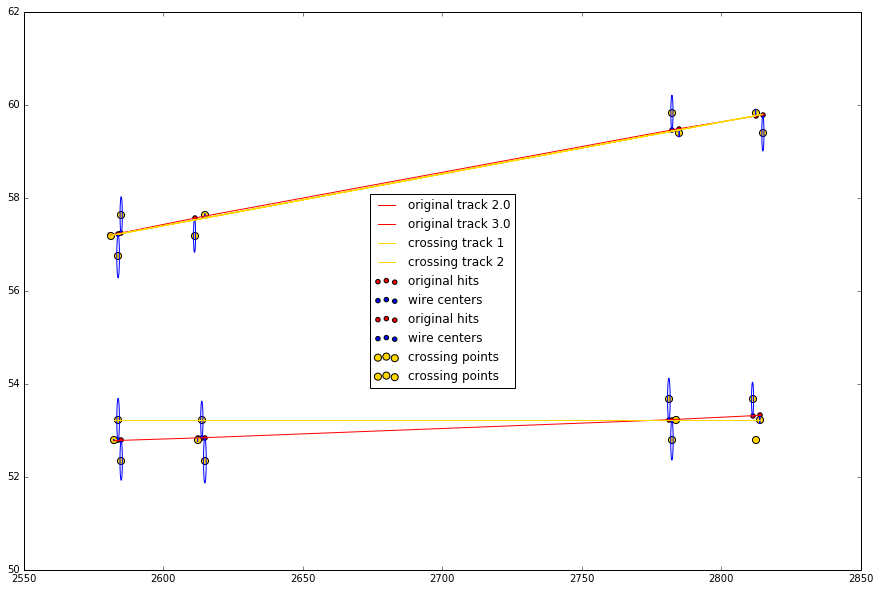

lin_regr
381:


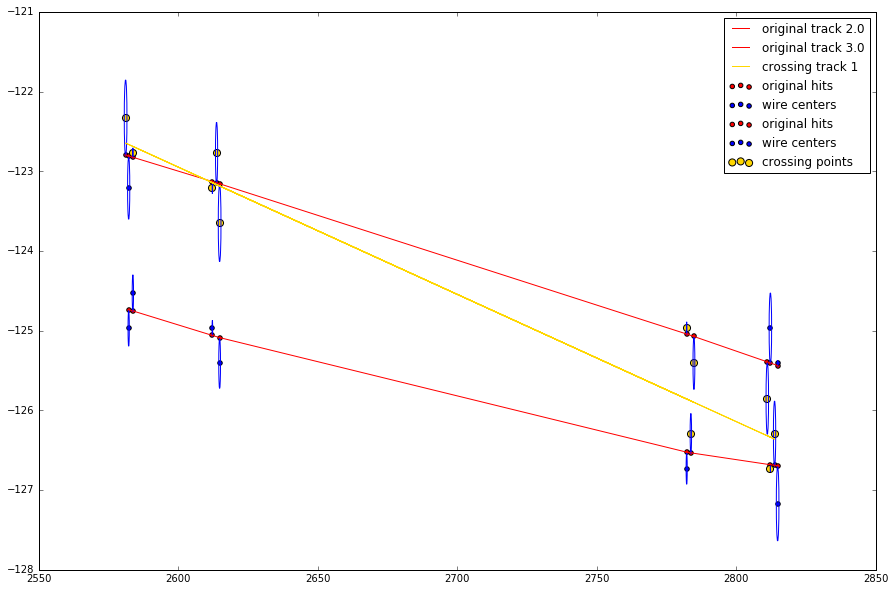

mlr
381:


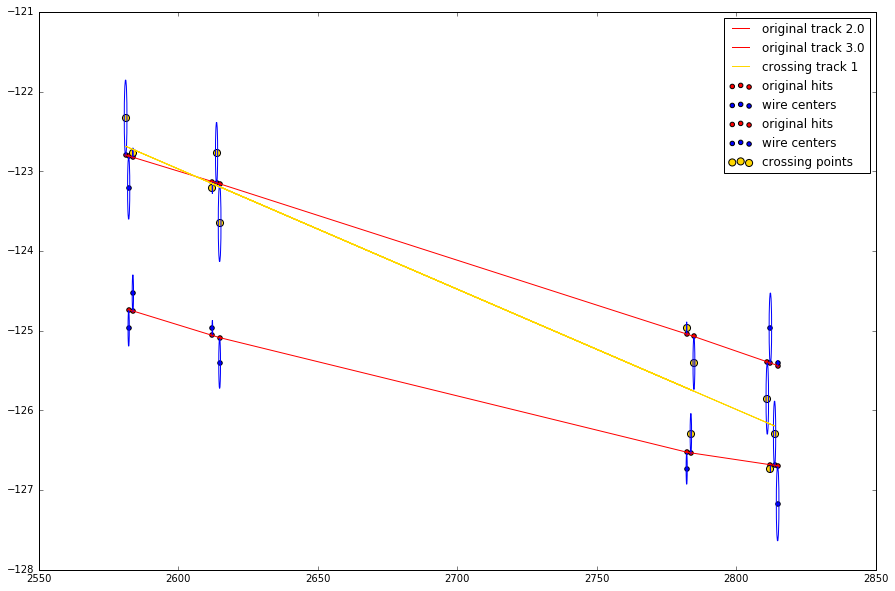

ransac
381:


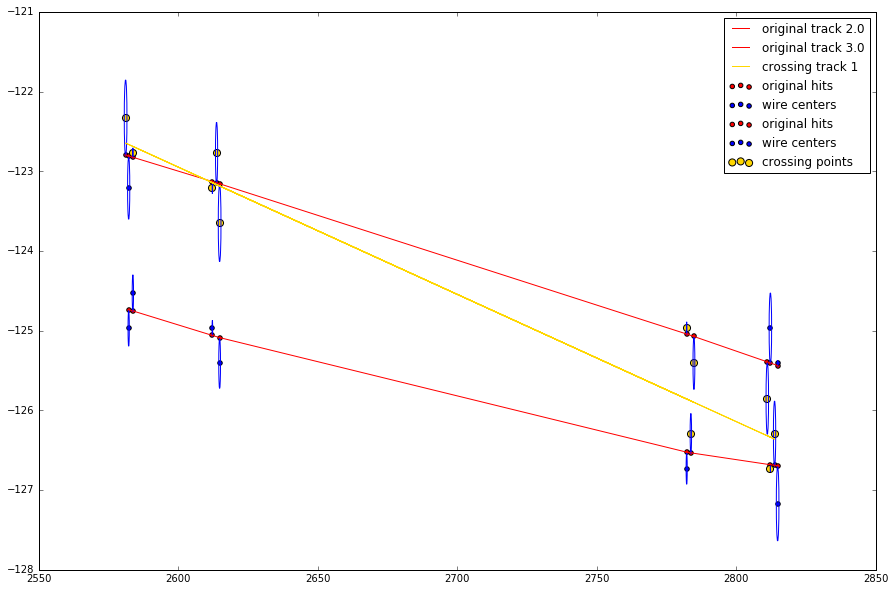

lin_regr
970:


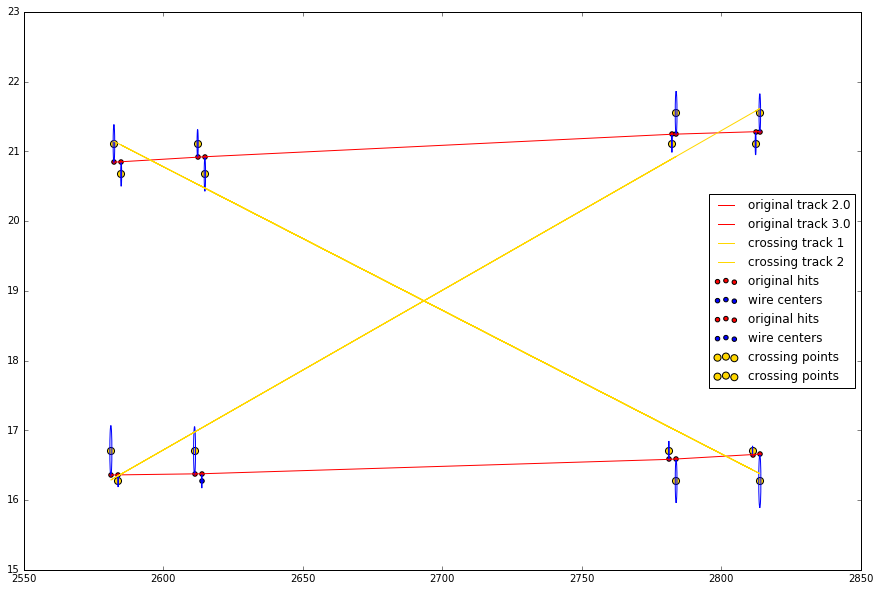

mlr
970:


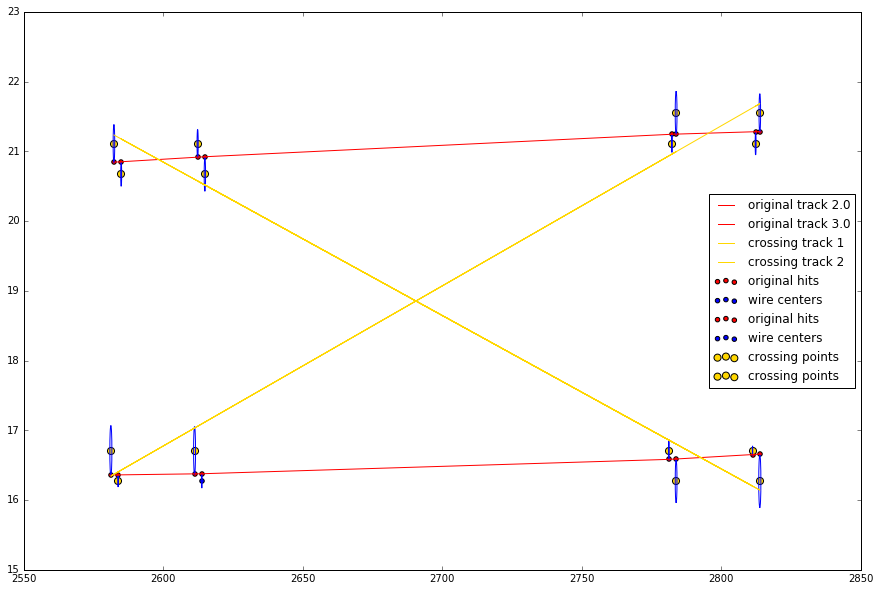

ransac
970:


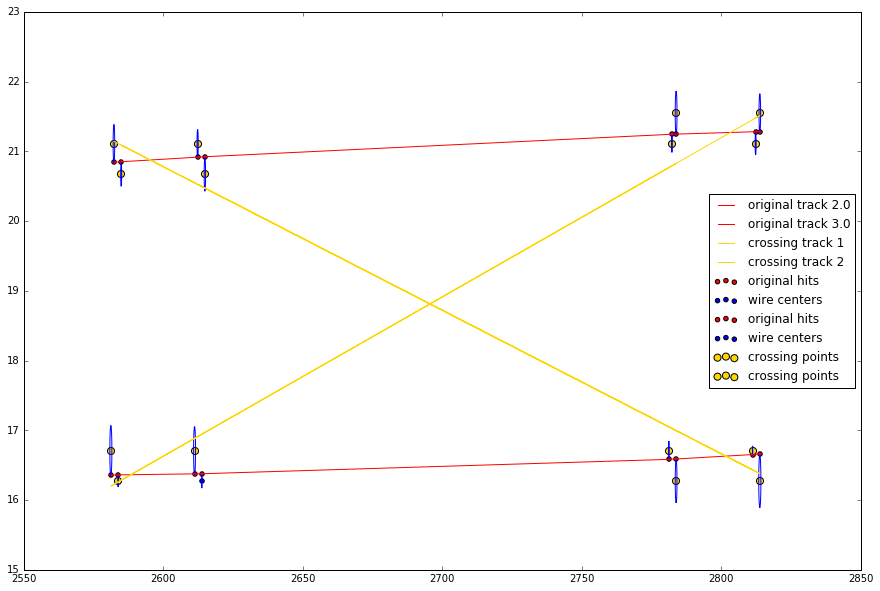

lin_regr
2040:


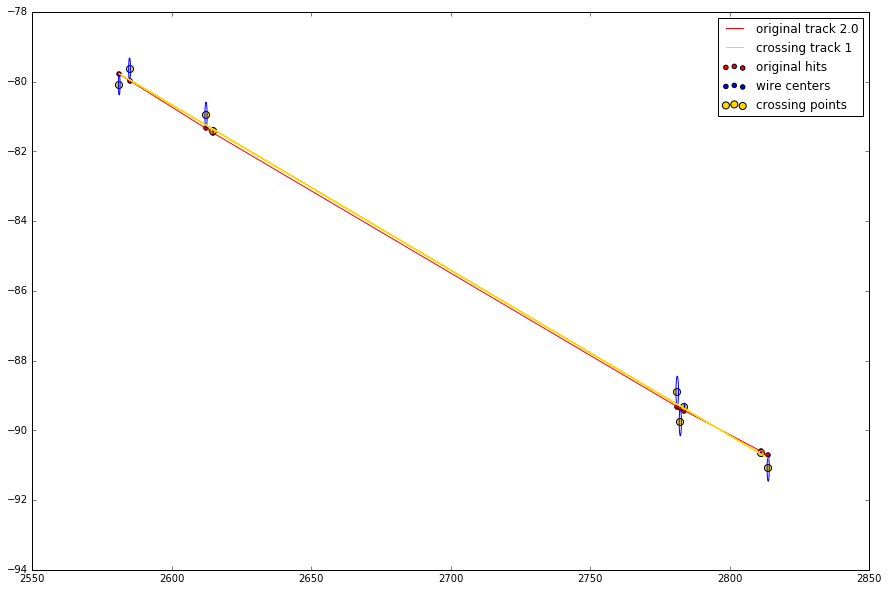

mlr
2040:


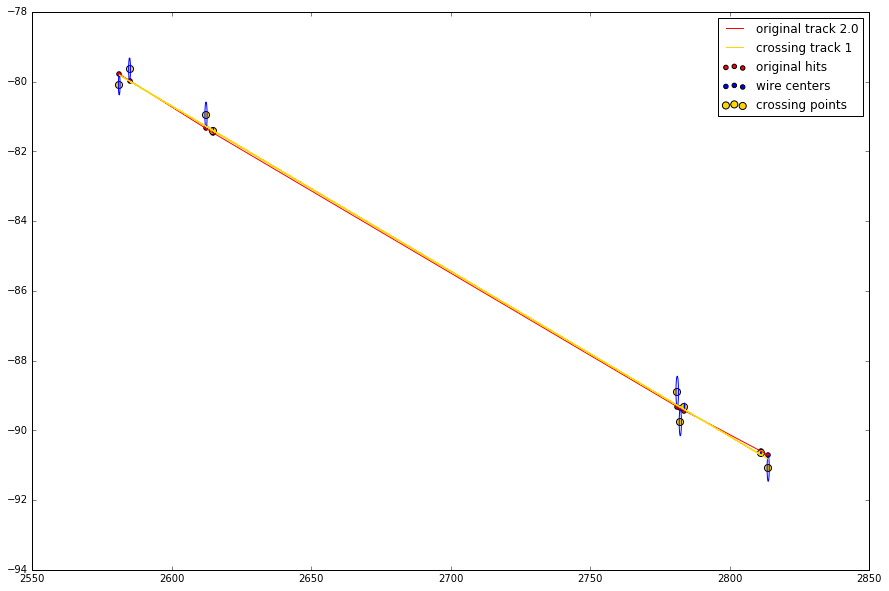

ransac
2040:


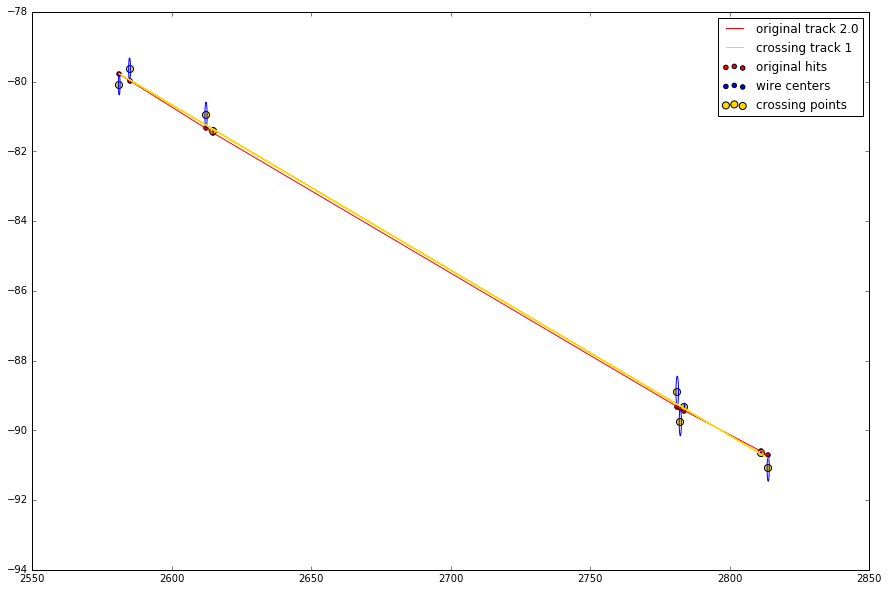

lin_regr
2029:


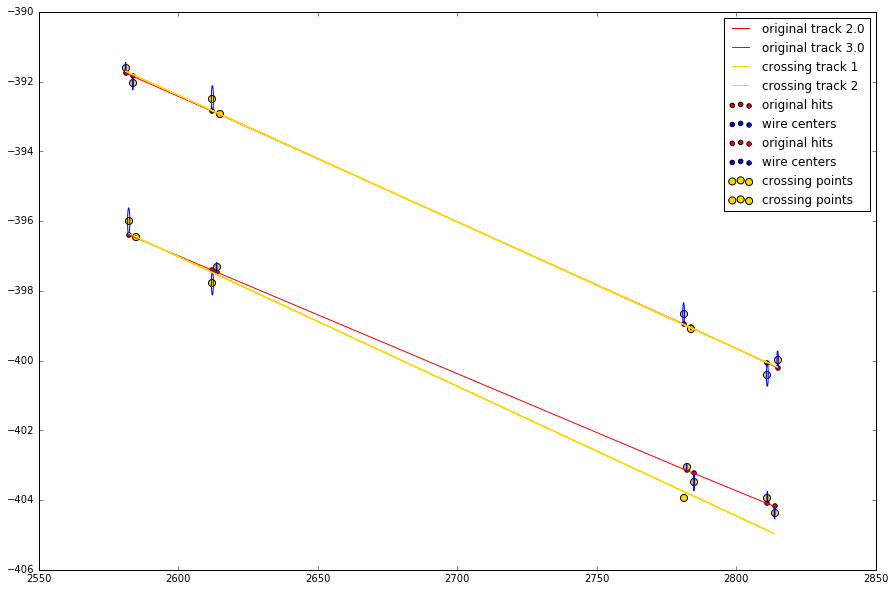

mlr
2029:


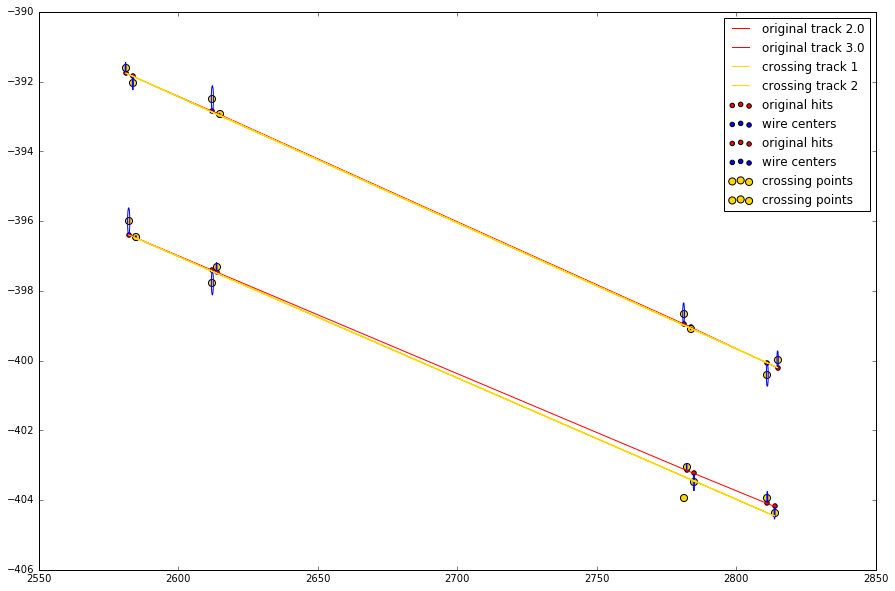

ransac
2029:


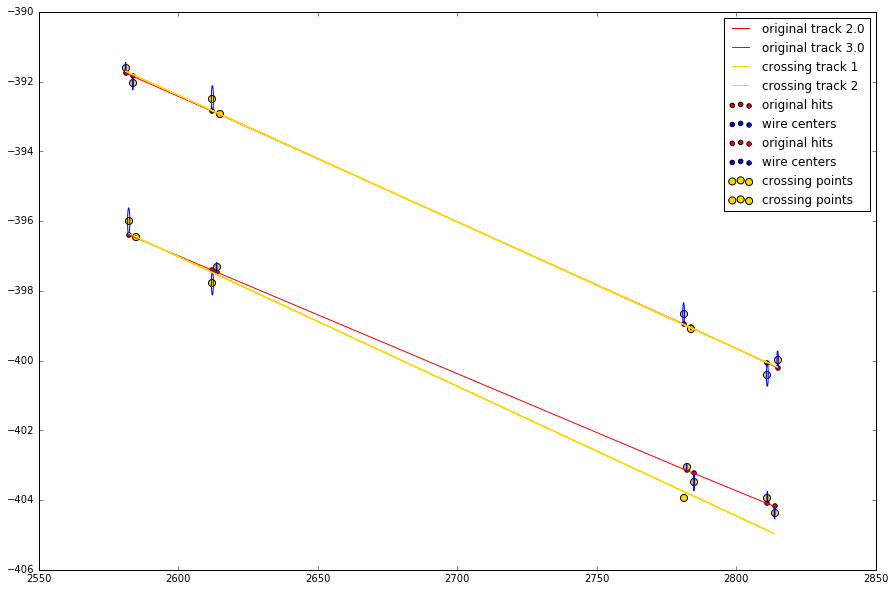

lin_regr
1533:


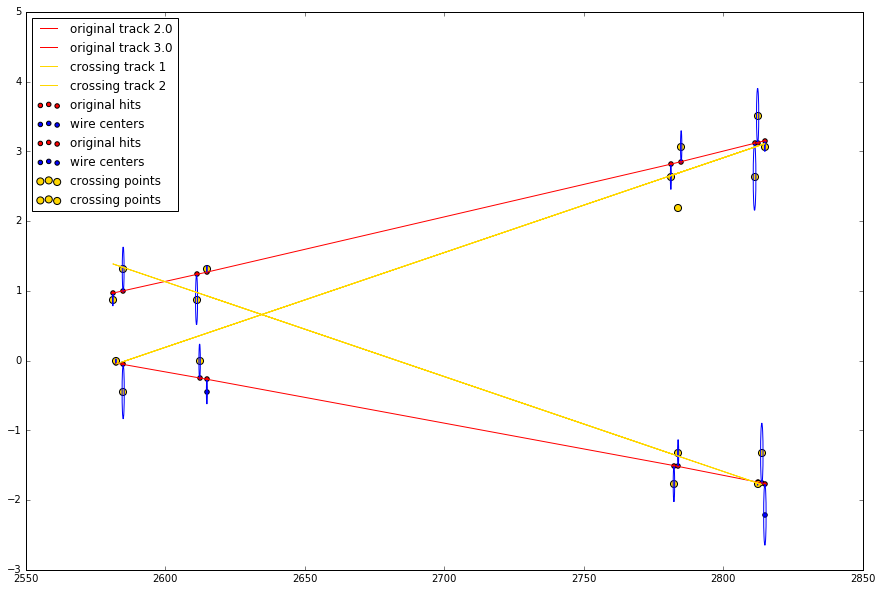

mlr
1533:


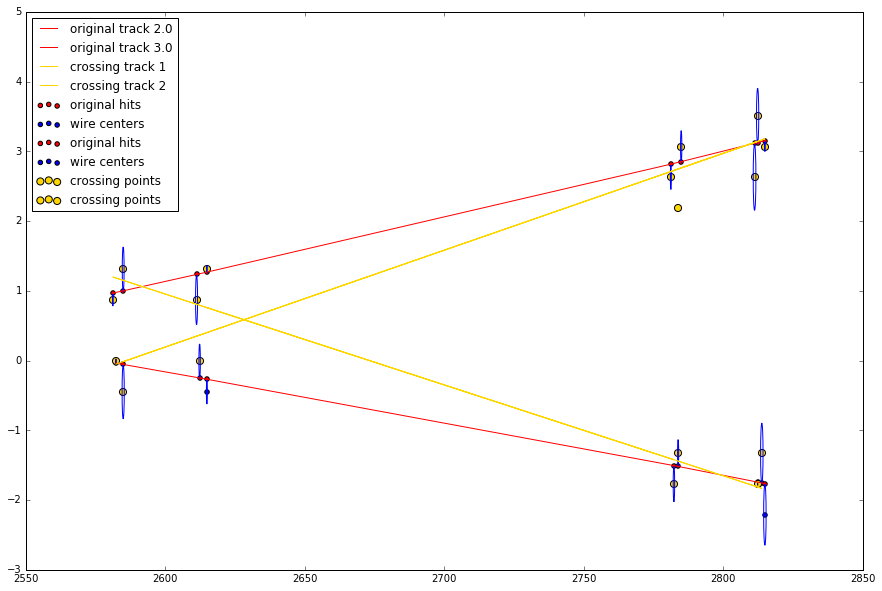

ransac
1533:


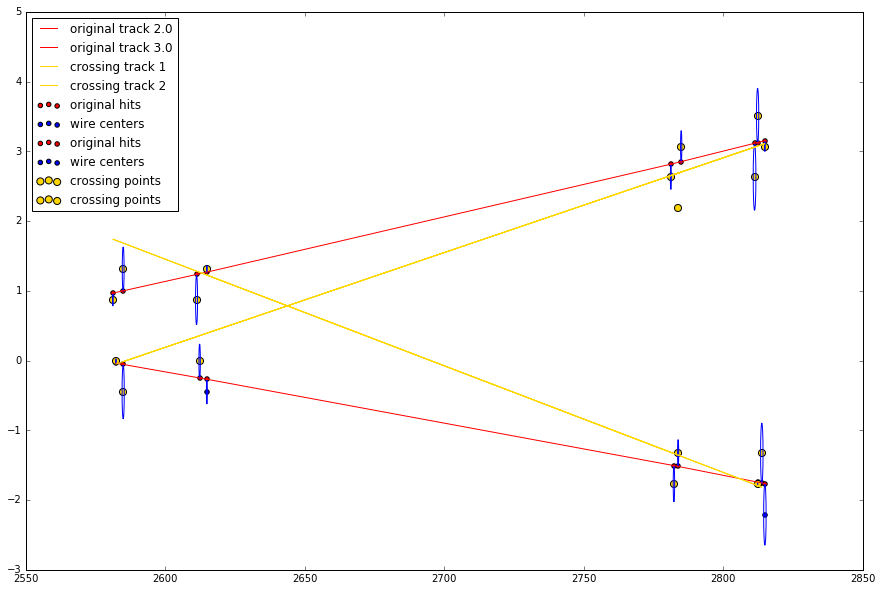

In [13]:
picture(bad_1)